# Report

---

In this notebook, I present how I use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

I begin by importing some necessary packages.  

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

I start the environment by pointing `file_name` to match the location of the Unity environment that I downloaded. 

In [2]:
env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here I check for the first brain available, and set it as the default brain I will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Training an Agent

#### Using Double DQN as My Learning Algorithm

Here is some pseudocode outlining the Double DQN implementation detail, along with the hyperparameters I used. 

```
BUFFER_SIZE = 1e5
M           = 1000
T           = 2000
BATCH_SIZE  = 64
GAMMA       = 0.99
LR          = 5e-4
C           = 4
TAU         = 1e-3

Initialize replay memory D of BUFFER_SIZE
Initialize online action-value function Q with random weights θ
Initialize target action-value function Q' with random weights θ'
For episode=1, M do
    For t=1, T do
        With probability ε select a random action a0
        Otherwise select a0=argmax Q(s0, a; θ)
        Execute a0 and observe r0, s1
        Store (s0, a0, r0, s1, done) in D
        
        If the size of D is greater than BATCH_SIZE
        Sample a random minibatch of BATCH_SIZE in D
        For each batch (s_i, a_i, r_i, s_j, done)
        Caculate TD_target
            if s_j is the terminating episode
                TD_target = r_i
            else
                TD_target = r_i + GAMMA * Q'(s_j, argmax Q(s0, a; θ); θ')
        Calculate TD_diff = TD_target - Q(s_i, a_i; θ)
        Perform a gradient descent step with learning rate LR and update θ
        Every C steps reset Q'= Q using a soft update of TAU
    END FOR
END FOR
```

In [5]:
from double_dqn_agent import Agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

In [6]:
def double_dqn(n_episodes=1000, max_t=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name] 
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
 
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(
                i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(
                i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = double_dqn()

Episode 100	Average Score: 0.67
Episode 200	Average Score: 4.40
Episode 300	Average Score: 7.48
Episode 400	Average Score: 10.23

Environment solved in 386 episodes!	Average Score: 13.02


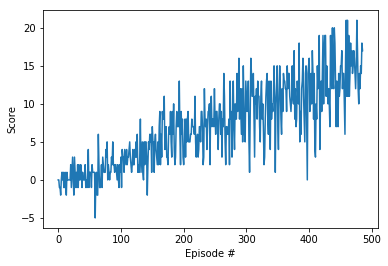

In [7]:
# plot the rewards
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Double DQN agent

In [12]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint_best.pth'))

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state)
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll oaver the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 19.0


In [11]:
env.close()

### 5. Future Work

I have done minimum work to adapt the DQN we implemented for the Lunar Lander project to a double DQN architecture for this project. I spent majority of my time understanding Double DQN. I am aware of other techniques that could further improve performance, such as prioritized experience replay and dueling DQN. Those are the ones I want to implement and compare with vanilla DQN and double DQN. 

I am also really interested in rewriting the code using TensorFlow estimators, in order to train it on Google Cloud Machine Learning Engine (CMLE), and perhaps use the hyperparameter tuning feature in CMLE for finding the best hyperparameters, instead of tuning it by hand. Stay tuned!